In [ ]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
#visualisation of function
def show(tensor, ch=1, size=(28,28), num=16):
  #tensor: 128x28x28
  data = tensor.detach().cpu().view(-1,ch,*size)
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)
  plt.imshow(grid)
  plt.show()

In [ ]:
#set up main parameters and hyperparameters
epochs = 500
cur_step =0
info_step=300
mean_gen_loss =0
mean_disc_loss =0
z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'

dataloader=DataLoader(MNIST('.',download=True, transform=transforms.ToTensor()), shuffle = True, batch_size=bs)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.75MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
#generator
def genBlock(inp ,out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), # 64, 128
        genBlock(h_dim, h_dim*2), # 128, 256
        genBlock(h_dim*2, h_dim*4), # 256 x 512
        genBlock(h_dim*4, h_dim*8), # 512, 1024
        nn.Linear(h_dim*8, i_dim), # 1024, 784 (28x28)
        nn.Sigmoid(),
    )

  def forward(self, noise):
       return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

## Discriminator
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4), # 784, 1024
        discBlock(h_dim*4, h_dim*2), # 1024, 512
        discBlock(h_dim*2, h_dim), # 512, 256
        nn.Linear(h_dim, 1) # 256, 1
    )

  def forward(self, image):
      return self.disc(image)


In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([5, 6, 3, 8, 6, 3, 1, 7, 8, 9])


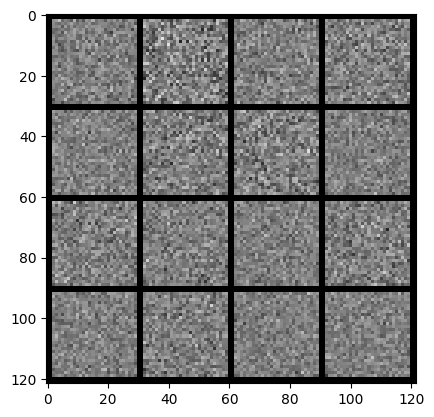

In [ ]:
x,y=next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

In [ ]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   pred = disc(fake)
   targets=torch.ones_like(pred)
   gen_loss=loss_func(pred,targets)

   return gen_loss


def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   disc_fake = disc(fake.detach())
   disc_fake_targets=torch.zeros_like(disc_fake)
   disc_fake_loss=loss_func(disc_fake, disc_fake_targets)

   disc_real = disc(real)
   disc_real_targets=torch.ones_like(disc_real)
   disc_real_loss=loss_func(disc_real, disc_real_targets)

   disc_loss=(disc_fake_loss+disc_real_loss)/2

   return disc_loss

  0%|          | 0/469 [00:00<?, ?it/s]

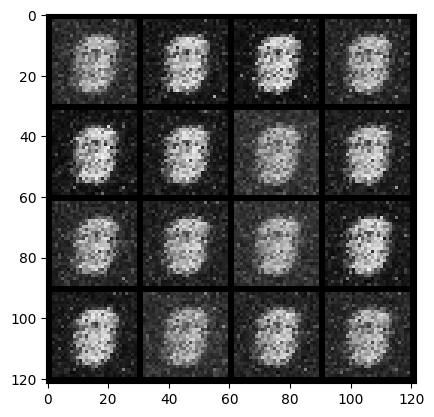

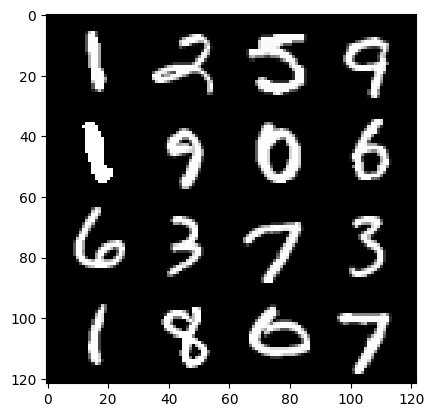

0: step 300 / Gen loss: 2.010469865004221 / disc_loss: 0.33554664952059554


  0%|          | 0/469 [00:00<?, ?it/s]

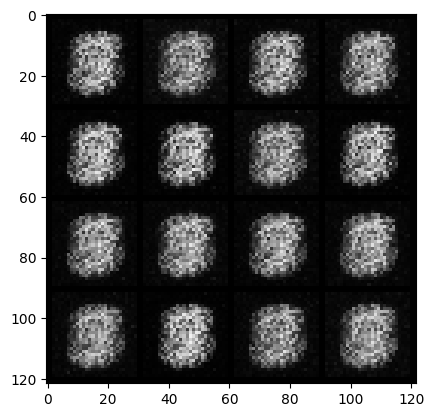

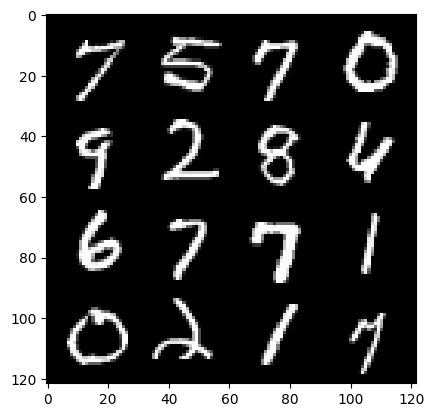

1: step 600 / Gen loss: 3.5600780232747384 / disc_loss: 0.1081685437013705


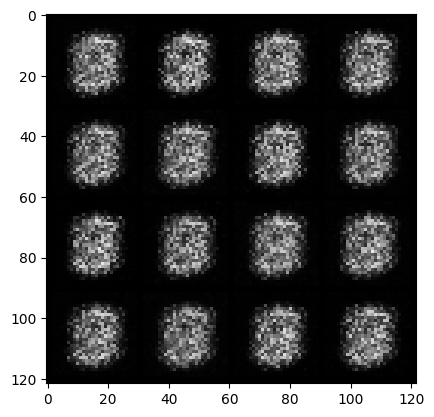

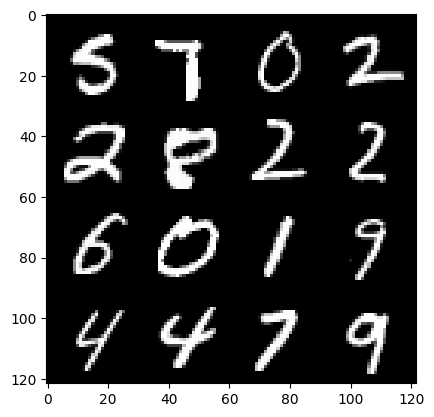

1: step 900 / Gen loss: 3.570650849342346 / disc_loss: 0.048493694576124374


  0%|          | 0/469 [00:00<?, ?it/s]

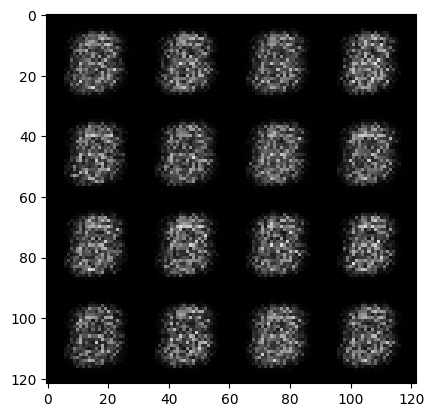

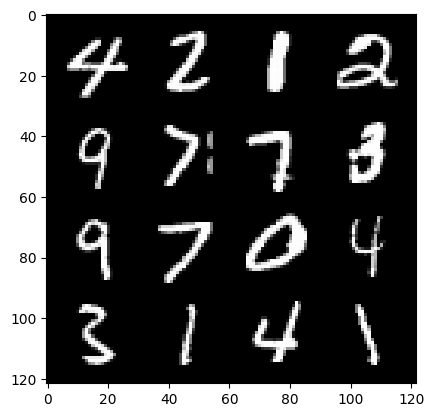

2: step 1200 / Gen loss: 3.6346957039833088 / disc_loss: 0.03327526009952029


  0%|          | 0/469 [00:00<?, ?it/s]

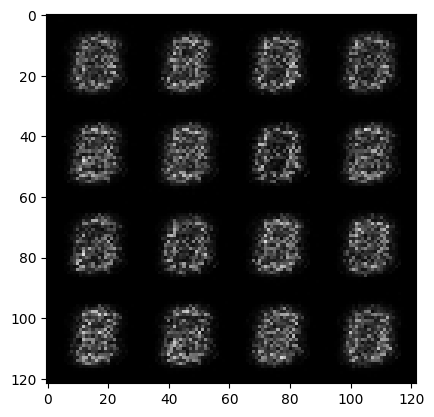

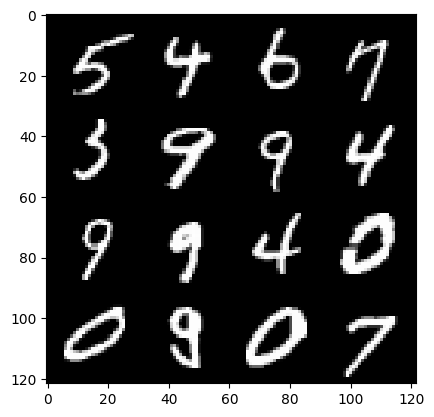

3: step 1500 / Gen loss: 3.4922643677393603 / disc_loss: 0.0399913143304487


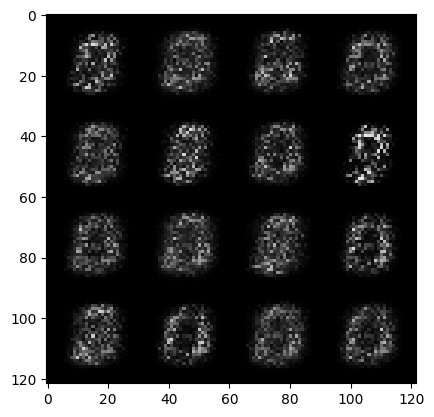

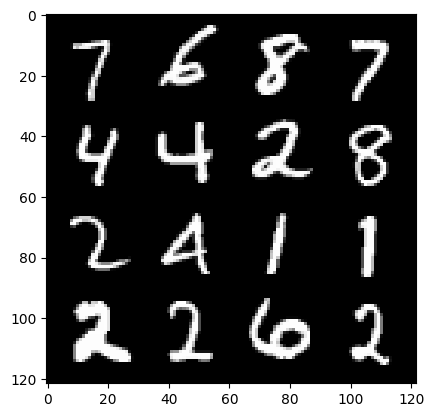

3: step 1800 / Gen loss: 3.3459987616539 / disc_loss: 0.0561630554621418


  0%|          | 0/469 [00:00<?, ?it/s]

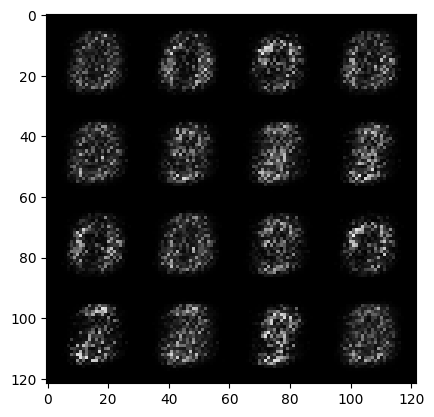

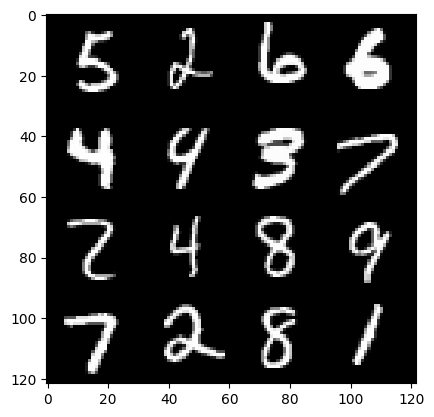

4: step 2100 / Gen loss: 3.5255995353062928 / disc_loss: 0.053850938826799394


  0%|          | 0/469 [00:00<?, ?it/s]

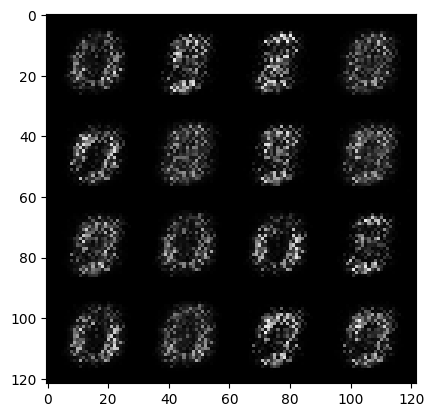

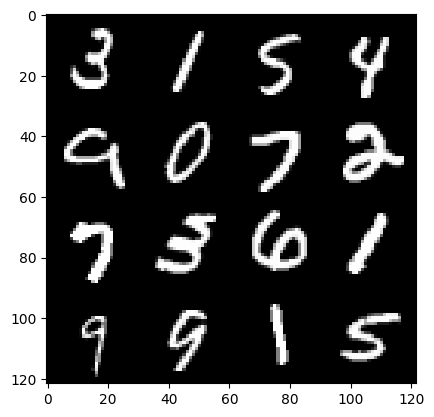

5: step 2400 / Gen loss: 3.7839608422915125 / disc_loss: 0.040351909982661416


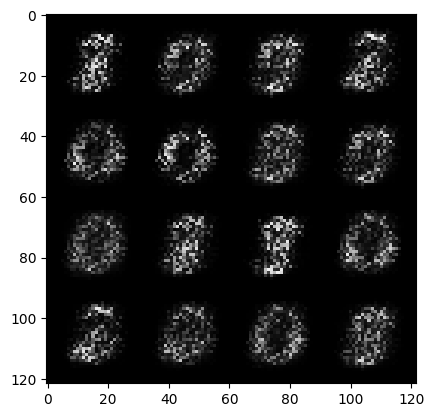

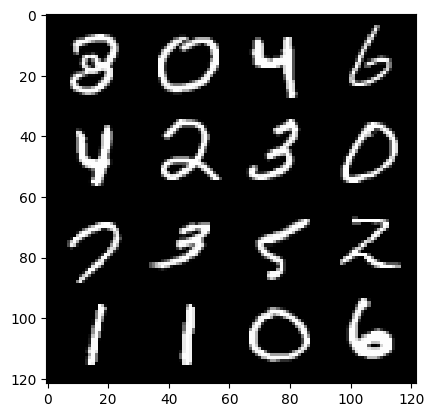

5: step 2700 / Gen loss: 4.448902423381806 / disc_loss: 0.02610854500283797


  0%|          | 0/469 [00:00<?, ?it/s]

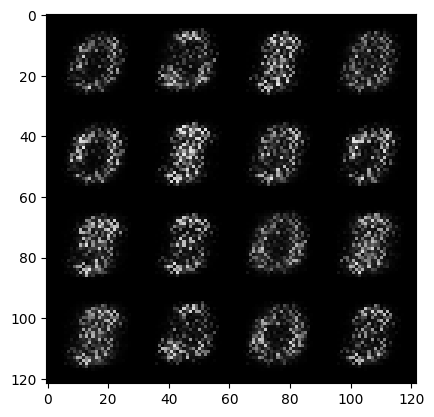

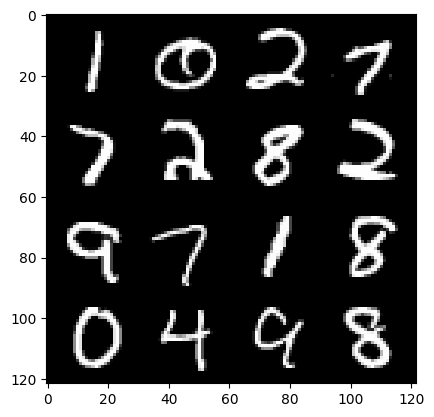

6: step 3000 / Gen loss: 4.893108510971075 / disc_loss: 0.019946724859376742


  0%|          | 0/469 [00:00<?, ?it/s]

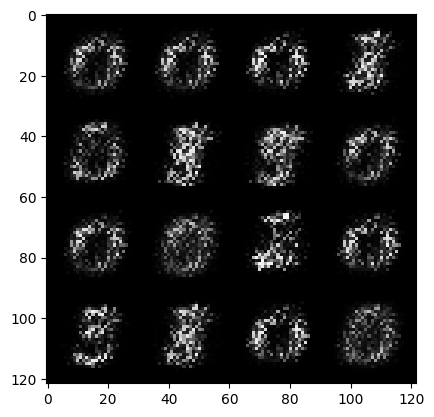

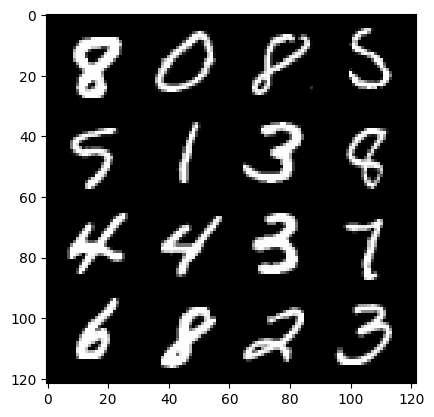

7: step 3300 / Gen loss: 4.945022452672324 / disc_loss: 0.01724269567367932


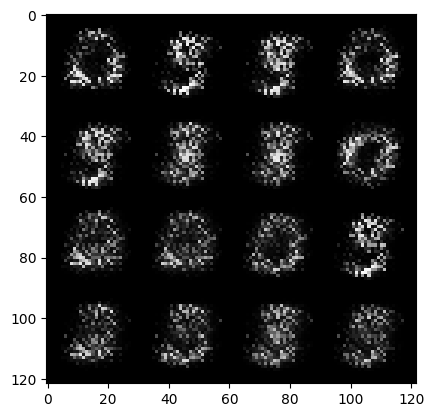

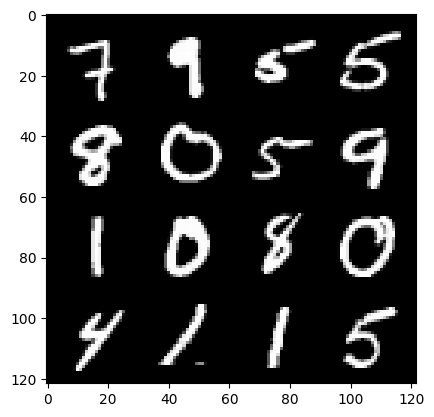

7: step 3600 / Gen loss: 5.355144383112591 / disc_loss: 0.016242196058544024


  0%|          | 0/469 [00:00<?, ?it/s]

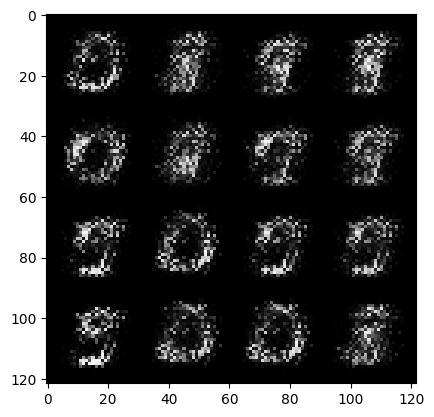

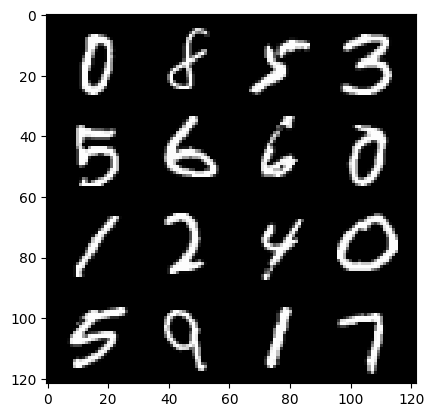

8: step 3900 / Gen loss: 5.71703023433685 / disc_loss: 0.015628685105281568


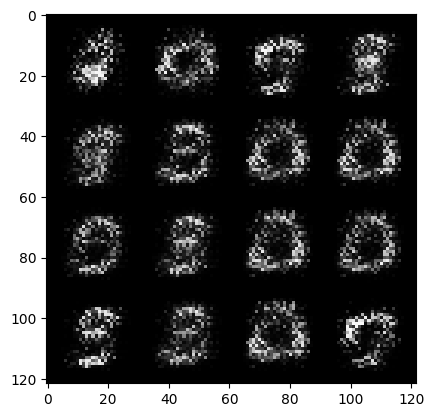

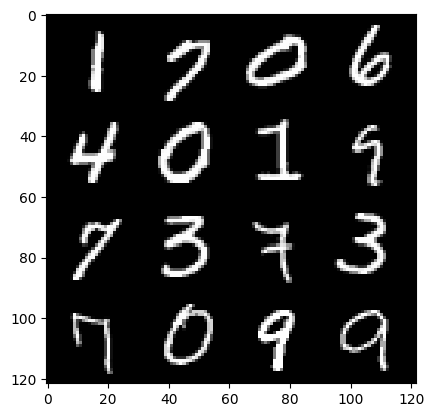

8: step 4200 / Gen loss: 5.794751021067301 / disc_loss: 0.016866981800024727


  0%|          | 0/469 [00:00<?, ?it/s]

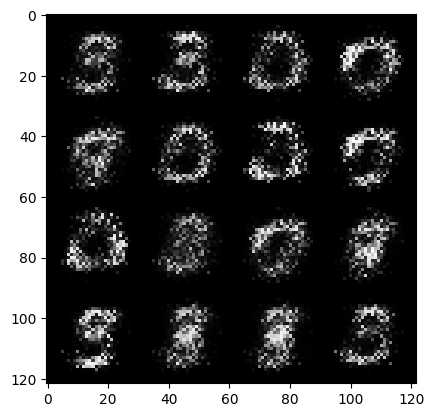

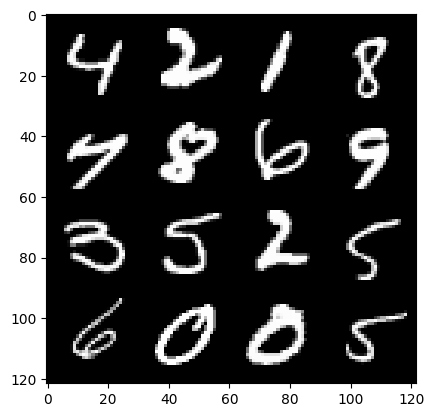

9: step 4500 / Gen loss: 6.121078405380249 / disc_loss: 0.01429603422215829


  0%|          | 0/469 [00:00<?, ?it/s]

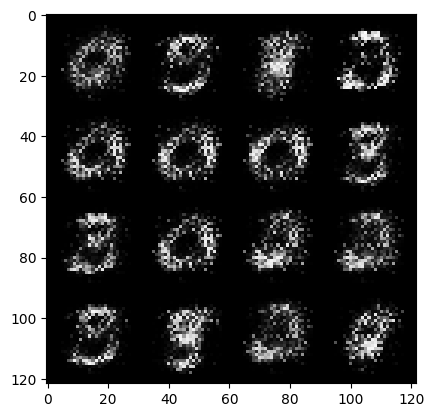

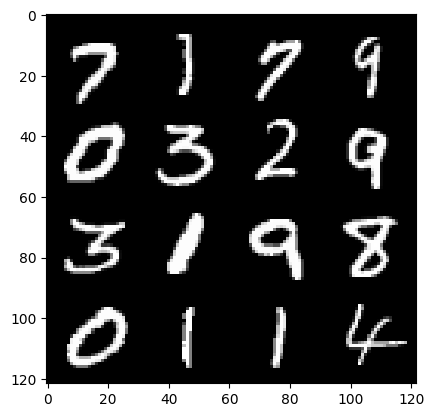

10: step 4800 / Gen loss: 6.041811003684999 / disc_loss: 0.012445293058020368


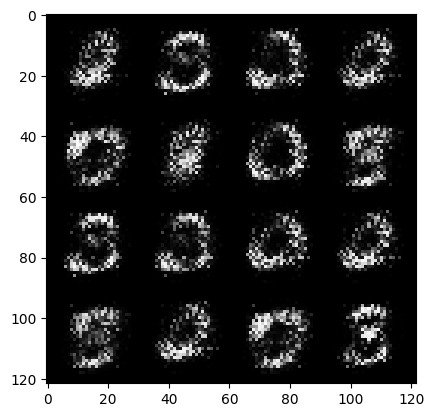

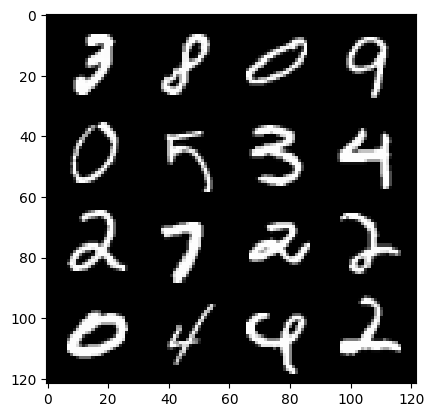

10: step 5100 / Gen loss: 5.918993973731998 / disc_loss: 0.01136403918964788


  0%|          | 0/469 [00:00<?, ?it/s]

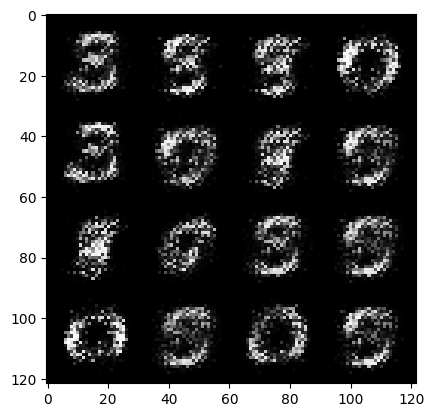

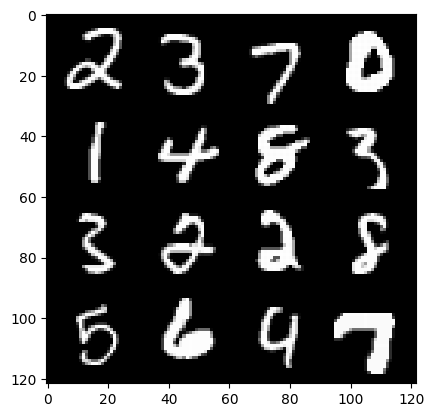

11: step 5400 / Gen loss: 6.068019344011945 / disc_loss: 0.009709851065029699


  0%|          | 0/469 [00:00<?, ?it/s]

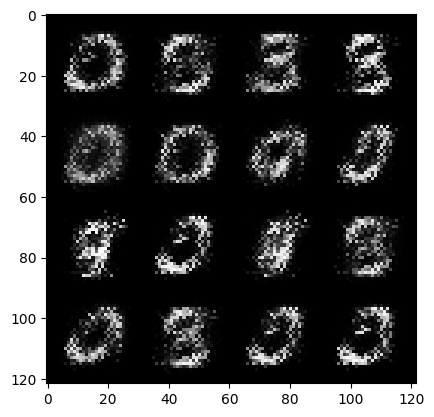

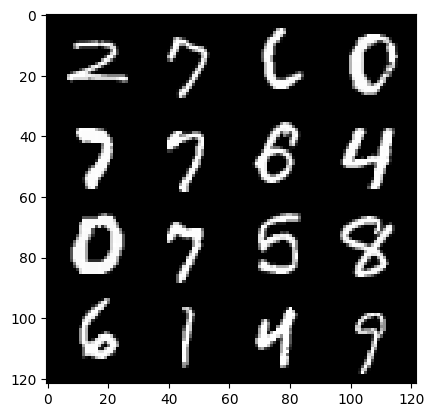

12: step 5700 / Gen loss: 6.582187015215553 / disc_loss: 0.01090732181367155


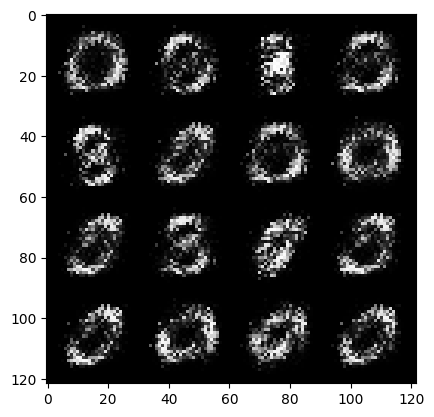

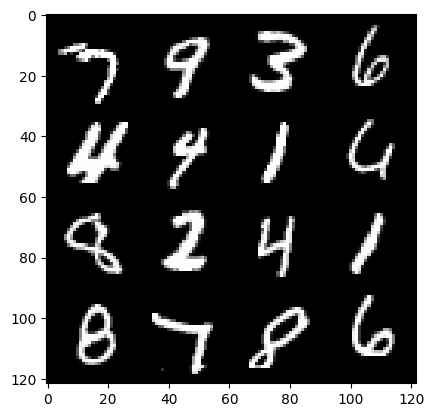

12: step 6000 / Gen loss: 7.077721263567609 / disc_loss: 0.013364489942323417


  0%|          | 0/469 [00:00<?, ?it/s]

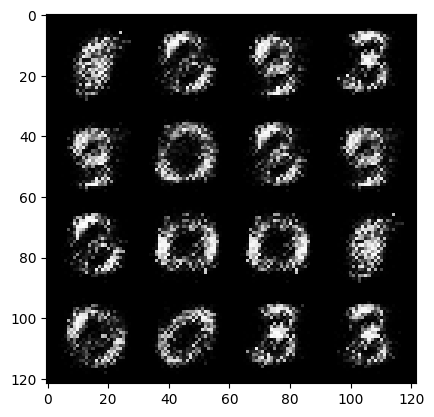

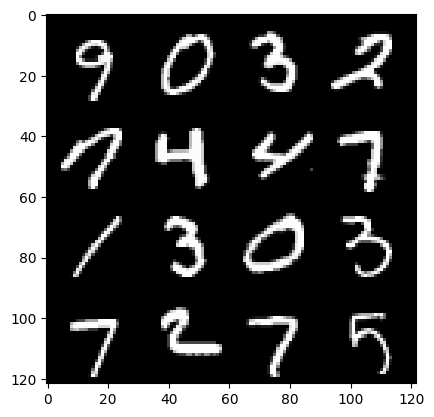

13: step 6300 / Gen loss: 6.316796828905746 / disc_loss: 0.014521695578781265


  0%|          | 0/469 [00:00<?, ?it/s]

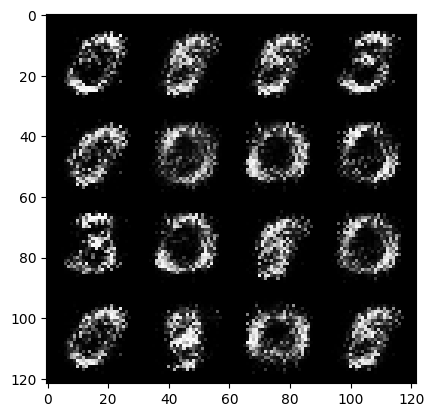

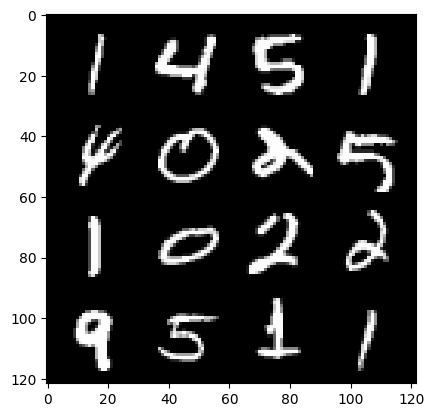

14: step 6600 / Gen loss: 6.325541582107546 / disc_loss: 0.014168891621132685


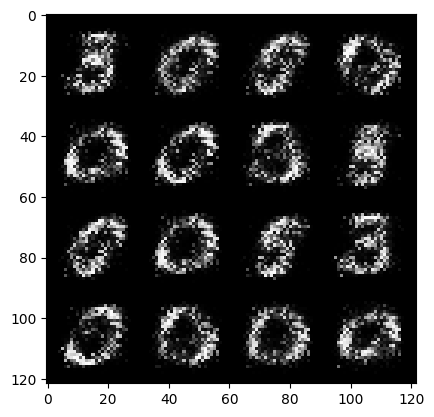

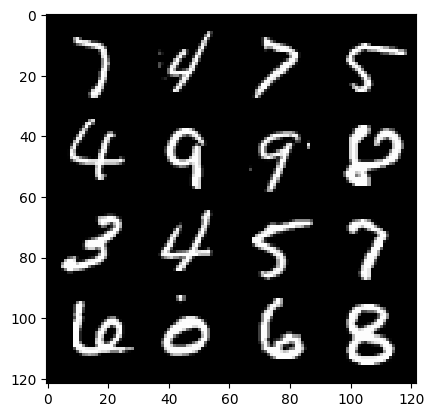

14: step 6900 / Gen loss: 6.38738885243734 / disc_loss: 0.011607833399903037


  0%|          | 0/469 [00:00<?, ?it/s]

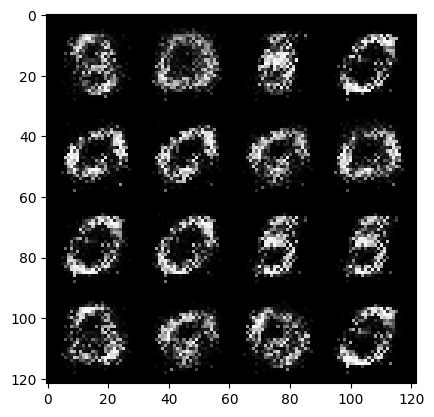

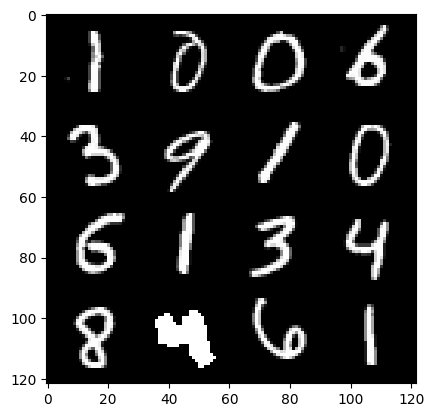

15: step 7200 / Gen loss: 6.661431632041932 / disc_loss: 0.01001245119531329


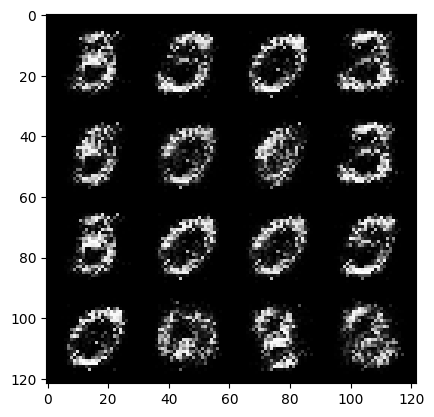

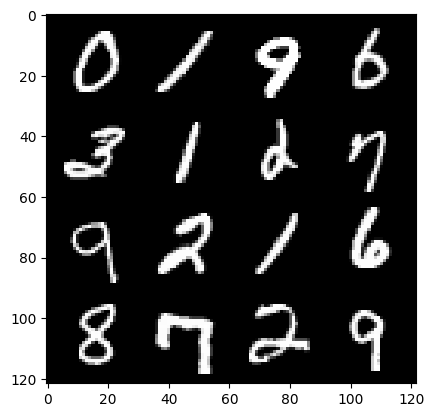

15: step 7500 / Gen loss: 7.066728442509972 / disc_loss: 0.009184798583543546


  0%|          | 0/469 [00:00<?, ?it/s]

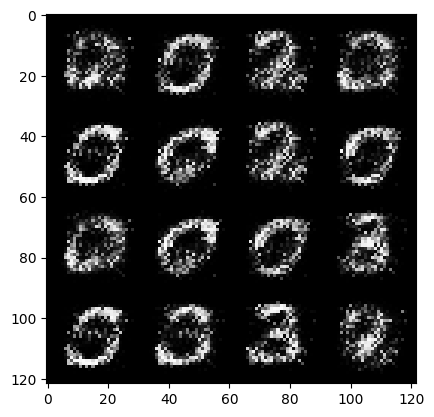

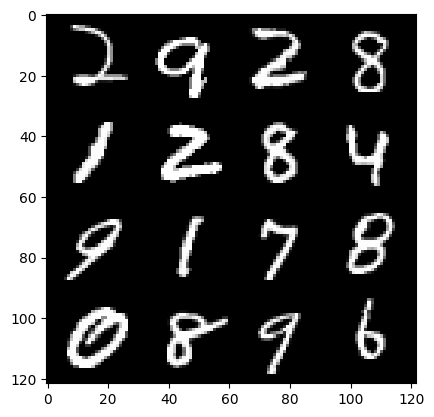

16: step 7800 / Gen loss: 7.133989836374918 / disc_loss: 0.00936238183174282


  0%|          | 0/469 [00:00<?, ?it/s]

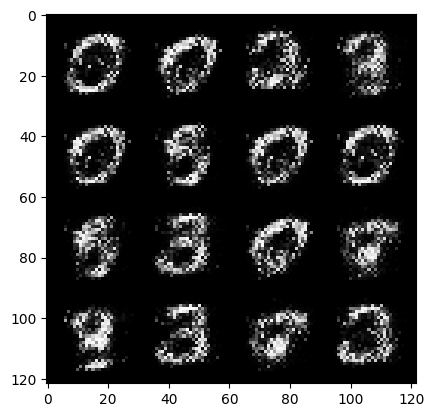

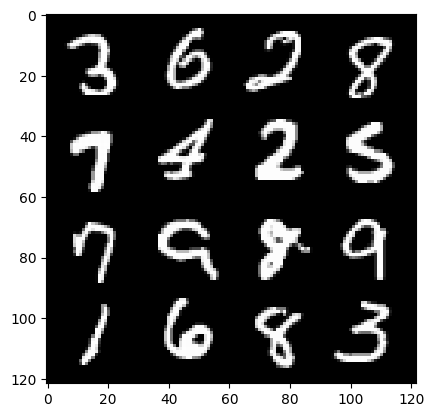

17: step 8100 / Gen loss: 7.035065323511758 / disc_loss: 0.011142785777337851


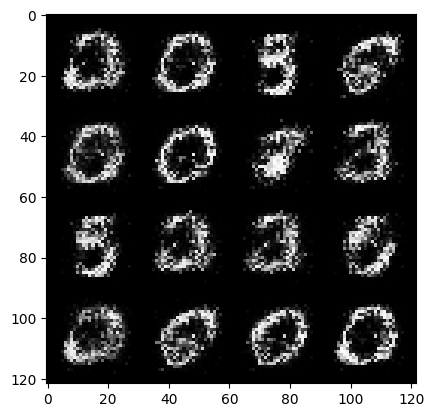

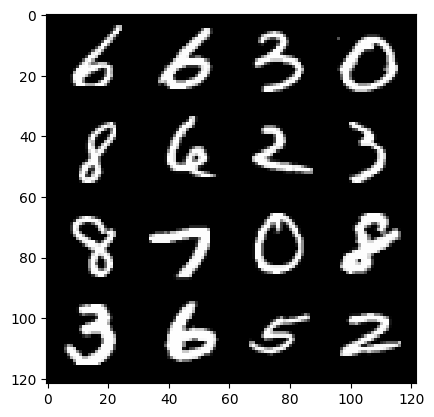

17: step 8400 / Gen loss: 7.17007485707601 / disc_loss: 0.010641793819765252


  0%|          | 0/469 [00:00<?, ?it/s]

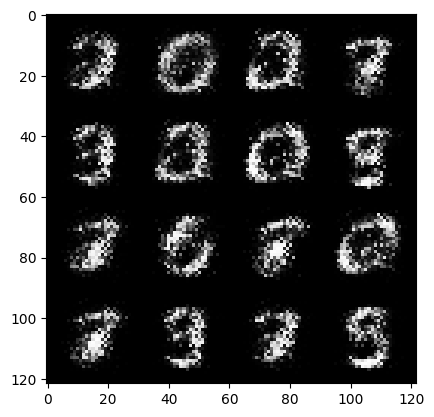

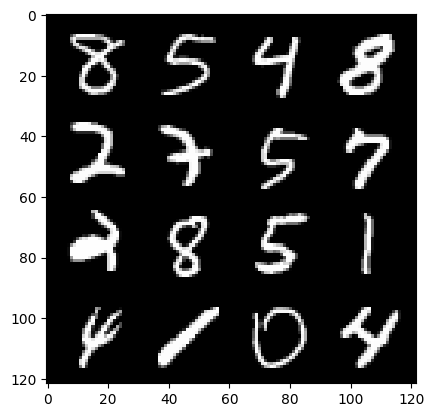

18: step 8700 / Gen loss: 7.148504778544107 / disc_loss: 0.010924877111101516


  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
### 60000 / 128 = 468.75  = 469 steps in each epoch
### Each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_opt.zero_grad()

    cur_bs=len(real) # real: 128 x 1 x 28 x 28
    real = real.view(cur_bs, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ### visualization & stats
    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step+=1